In [1]:
import geopandas as gpd
import folium
import pandas as pd
import matplotlib.pyplot as plt
from shapely.geometry import shape

In [2]:
df = pd.read_csv('../validation_data/table_validation_bursts_target_v0.2.csv')
df.columns = ['burst_id','Date','cslc_url','static_layer_url','geometry']
df['Date'] = pd.to_datetime(df['Date'],format='%Y%m%d')
df = df.drop_duplicates(subset=['burst_id'],ignore_index=True)
df.head()

,burst_id,Date,cslc_url,static_layer_url,geometry
0,t004_006658_iw3,2015-03-10,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,"POLYGON ((-76.38300845090444 36.6726888086453,..."
1,t004_006660_iw3,2015-03-10,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,POLYGON ((-76.45402105493196 37.00393449235948...
2,t034_071054_iw2,2016-04-12,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,POLYGON ((-96.39267548902326 29.52630149346994...
3,t034_071054_iw3,2016-04-12,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,POLYGON ((-95.50826042302305 29.72577617196962...
4,t034_071087_iw3,2015-03-13,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,s3://opera-pst-rs-pop1/products/CSLC_S1/OPERA_...,"POLYGON ((-96.63632026186636 35.2082123593953,..."


In [3]:
# Define ALE sites
# ALE_sites = ['t064_135523_iw1',
# 't064_135523_iw2',
# 't071_151224_iw2',
# 't094_200136_iw2',
# 't094_200136_iw3',
# 't107_227888_iw2',
# 't131_279917_iw1',
# 't160_342208_iw3',
# 't160_342212_iw1']

ALE_sites = ['t064_135523_iw1',
't107_227888_iw2',
't160_342208_iw3']

# Read geometry column as wkt
df['geometry'] = gpd.GeoSeries.from_wkt(df['geometry'])
gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=df.geometry)
df = None

/tmp/ipykernel_25047/3508755808.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
/tmp/ipykernel_25047/3508755808.py:10: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_ALE.centroid.plot(color='b', marker='*', markersize=80, ax=ax)


Text(0.5, 1.0, 'OPERA CSLC CalVal Sites')

<Figure size 640x480 with 0 Axes>

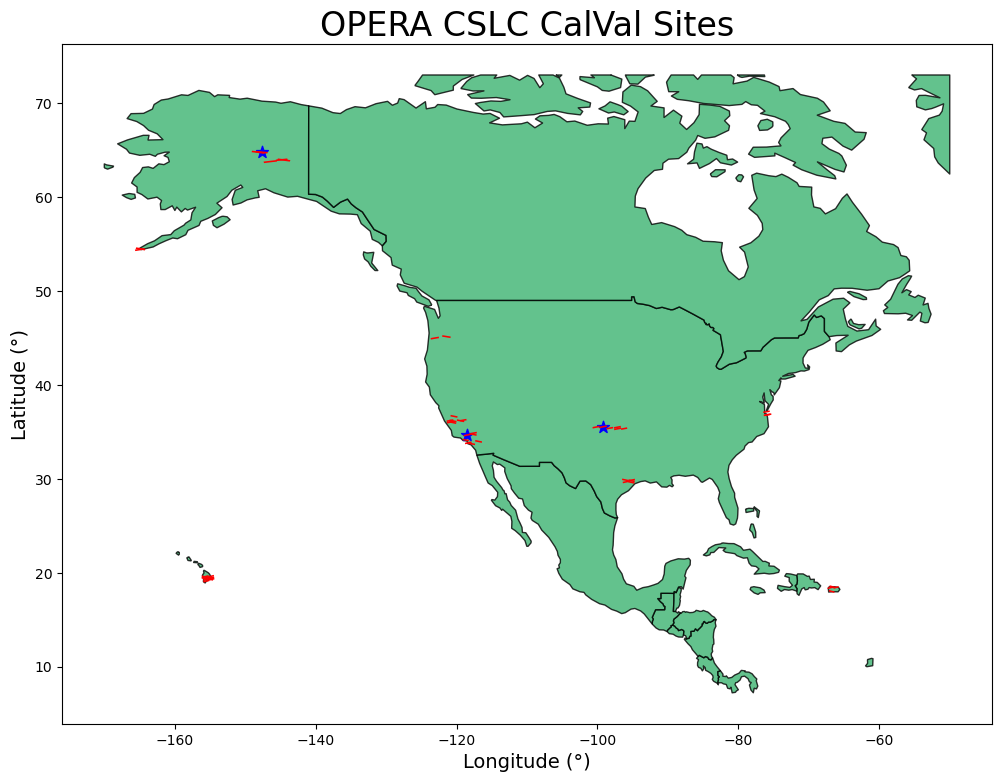

In [4]:
# Get Map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
NorthAmerica = world[world.continent=='North America']
NorthAmerica = NorthAmerica.clip([-170,7,-50,73]).to_crs("EPSG:4326")
gdf_ALE = gdf[gdf.burst_id.isin(ALE_sites)]

# Plot 
fig = plt.figure()
ax = NorthAmerica.plot(figsize=(12,12), color='mediumseagreen', alpha=0.8, edgecolor="black")
gdf_ALE.centroid.plot(color='b', marker='*', markersize=80, ax=ax)
gdf.plot(color='r', ax=ax)
ax.set_xlabel(f'Longitude (\N{DEGREE SIGN})', fontsize=14)
ax.set_ylabel('Latitude (\N{DEGREE SIGN})', fontsize=14)
ax.set_title('OPERA CSLC CalVal Sites', fontsize=24)


In [5]:
def getbasemaps():
    # Add custom base maps to folium
    basemaps = {
        'Google Satellite Hybrid': folium.TileLayer(
            tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
            attr = 'Google',
            name = 'Google Satellite',
            overlay = True,
            control = True,
            # opacity = 0.8,
            show = False
        ),
        'Esri Satellite': folium.TileLayer(
            tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr = 'Esri',
            name = 'Esri Satellite',
            overlay = True,
            control = True,
            #opacity = 0.8,
            show = False
        )
    }
    return basemaps

In [6]:
# Interactive map
m = folium.Map(location=[40, -100], zoom_start=4.3, tiles="CartoDB positron")

# Add custom basemaps
basemaps = getbasemaps()
for basemap in basemaps:
    basemaps[basemap].add_to(m)

# layer Control
m.add_child(folium.LayerControl())

## RLE sites
for _, r in gdf.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"color": "red"}, control=False)
    folium.Popup(r["burst_id"]).add_to(geo_j)
    geo_j.add_to(m)

## ALE sites
for _, r in gdf_ALE.iterrows():
    sim_geo = gpd.GeoSeries(r["geometry"]).centroid
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(data=geo_j, style_function=lambda x: {"iconColor": "orange"}, control=False)
    folium.Popup(r["burst_id"]).add_to(geo_j)
    geo_j.add_to(m)

# Display
m